In [ ]:
!ln -sf /content/drive/MyDrive/ConvertedGaitData/Stabalized/front/GEI /content/GEI

In [ ]:
import cv2
img = cv2.imread("/content/GEI/Sub0/S_0.png",cv2.IMREAD_UNCHANGED)

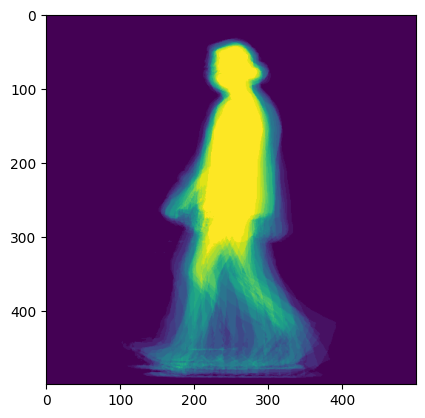

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(img)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import os
def drop_labels_with_few_instances(df, label_column, n):
    # Count the instances of each label
    label_counts = df[label_column].value_counts()

    # Identify labels with at least n instances
    labels_to_keep = label_counts[label_counts >= n].index

    # Filter the DataFrame to keep only those labels
    filtered_df = df[df[label_column].isin(labels_to_keep)]

    # Create a mapping from original labels to new sequential labels
    label_mapping = {label: i for i, label in enumerate(labels_to_keep)}

    # Apply the mapping to the label column
    filtered_df[label_column] = filtered_df[label_column].map(label_mapping)

    return filtered_df

def prepare_datasets(data_dir,csv_file, test_size=0.2,n=10):
    csv_path = os.path.join(data_dir,csv_file)
    # Read the CSV file
    data = pd.read_csv(csv_path)
    filtered_data = drop_labels_with_few_instances(data,"Label",n)
    # Initialize lists to store features and labels
    features = []
    labels = []

    # Load images and convert them to numpy arrays
    for index, row in filtered_data.iterrows():
        img_path = row['Path']
        label = row['Label']
        path_img = os.path.join(data_dir,img_path)
        img = cv2.imread(path_img,cv2.IMREAD_UNCHANGED)
        features.append(img)
        labels.append(label)

    # Convert lists to numpy arrays
    features = np.array(features)
    labels = np.array(labels)

    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, stratify=labels, random_state=42)

    return X_train, X_test, y_train, y_test

In [ ]:
csv_file = 'gei.csv'
data_dir = '/content/GEI/'
X_train, X_test, y_train, y_test = prepare_datasets(data_dir,csv_file, test_size=0.2)
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


<ipython-input-5-490ea17d6c14>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[label_column] = filtered_df[label_column].map(label_mapping)


Training data shape: (361, 500, 500)
Testing data shape: (91, 500, 500)


Random Forest Search_ Flattened

In [ ]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 100)
model.fit(X_train.reshape(X_train.shape[0],-1), y_train)
y_pred = model.predict(X_test.reshape(X_test.shape[0],-1))
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           5       0.83      0.83      0.83         6
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         4
           8       0.75      0.75      0.75         4
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         4
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         4
          15       1.00      0.50      0.67         4
          16       0.83      1.00      0.91         5
          17       0.83      1.00      0.91         5
          18       1.00      1.00      1.00         5
          19       0.60      0.75      0.67         4
          20       1.00      0.75      0.86         4
          21       1.00    

Basic CNN

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Assume you have X_train, y_train, X_test, y_test prepared as numpy arrays

# Example data preprocessing (if needed)
# Normalize the pixel values
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
# Convert labels to categorical (one-hot encoding)
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(500, 500,1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy:.4f}')

# Make predictions (if needed)
predictions = model.predict(X_test)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 314ms/step - accuracy: 0.0464 - loss: 4.4690 - val_accuracy: 0.0548 - val_loss: 3.0348
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.1210 - loss: 3.0015 - val_accuracy: 0.1370 - val_loss: 2.9532
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.1630 - loss: 2.8537 - val_accuracy: 0.3562 - val_loss: 2.5756
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - accuracy: 0.2912 - loss: 2.4100 - val_accuracy: 0.3973 - val_loss: 2.0049
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.4340 - loss: 1.8704 - val_accuracy: 0.6986 - val_loss: 1.2366
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.5847 - loss: 1.2613 - val_accuracy: 0.6849 - val_loss: 0.9804
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.6929 - loss: 0.9355 - val_accuracy: 0.8082 - val_loss: 0.6671
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.7507 - loss: 0.7496 - val_accuracy: 0.8767 - val_loss: